## A brief introduction and background about AI4PDEs

The AI4PDEs code solves discretised systems with untrained neural networks. It is used to simulate incompressible Navier-Stokes equations which can be written in 2D as, 
$$
\frac{\partial \mathbf{q}}{\partial t} + u\frac{\partial \mathbf{q}}{\partial x} +  v\frac{\partial \mathbf{q}}{\partial y} + 
\sigma \mathbf{q} - \nu \nabla \cdot \nabla \mathbf{q} = -\nabla p \,
$$

$$
\nabla  \cdot \mathbf{q} = \mathbf{0} \,
$$
in which $\mathbf{q}=(u \;v)^T$ in 2D and $\mathbf{q}=(u\;v\;w)^T$ in 3D, $p$ is the pressure, $\sigma$ is an absorption term and $\nu$ is the viscosity coefficient. A projection based solution method formed by manipulating the 
discretised equations which results in the following procedure,
1. Solve for $\mathbf{q}^{n+1}$ using the two-step approach outlined for the Burgers and advection-diffusion equation but treating the term involving $\sigma$ fully implicitly:
$$
\frac{\mathbf{q}^{n+1} -\mathbf{q}^{n} }{\Delta t} + u^n\frac{\partial \mathbf{q}^{n+\frac{1}{2}} }{\partial x} +  v^n\frac{\partial \mathbf{q}^{n+\frac{1}{2}} }{\partial y} + 
\sigma \mathbf{q}^{n+1} - \nu \nabla \cdot \nabla \mathbf{q}^{n+\frac{1}{2}} = -\nabla p^n \,
$$
2. Solve for pressure correction $\Delta p$:
$$ 
\nabla^2 \Delta p = -\frac{1}{\Delta t} \nabla \cdot \mathbf{q}^{n+1}  
$$
3. Solve for the velocity correction $\Delta \mathbf{q}$ using the U-net structured multigrid solver
$$
\Delta \mathbf{q} = -\Delta t \nabla \Delta p. 
$$
4. Update pressure solution: $p^{n+1} = p^n + \Delta p$
5. Update velocity solution: $\mathbf{q}^{n+1} \leftarrow \mathbf{q}^{n+1} + \Delta \mathbf{q}$

## More details can be found in our recent publications,
+
Phillips TR, Heaney CE, Chen B, Buchan AG, Pain CC. [Solving the discretised neutron diffusion equations using neural networks](https://doi.org/10.1002/nme.7321). International Journal for Numerical Methods in Engineering. 2023 Nov 15;124(21):4659-86. 
+
Phillips TR, Heaney CE, Chen B, Buchan AG, Pain CC. [Solving the Discretised Boltzmann Transport Equations using Neural Networks: Applications in Neutron Transport](https://doi.org/10.48550/arXiv.2301.09991). arXiv preprint arXiv:2301.09991. 2023 Jan 24. 
+
Chen B, Heaney CE, Pain CC. [Using AI libraries for Incompressible Computational Fluid Dynamics](https://doi.org/10.48550/arXiv.2402.17913). arXiv preprint arXiv:2402.17913. 2024 Feb 27. 
+
Chen B, Heaney CE, Gomes JL, Matar OK, Pain CC. [Solving the Discretised Multiphase Flow Equations with Interface Capturing on Structured Grids Using Machine Learning Libraries]( https://doi.org/10.1016/j.cma.2024.116974). Computer Methods in Applied Mechanics and Engineering. 2024 June 1; 426: 0045-7825.

Contact: Prof Christopher C. Pain (c.pain@imperial.ac.uk), Dr Claire E. Heaney (c.heaney@imperial.ac.uk), Dr Boyang Chen (boyang.chen16@imperial.ac.uk). [Applied Modelling and Computation Group](https://www.imperial.ac.uk/earth-science/research/research-groups/amcg/), Department of Earth Science and Engineering, Imperial College London

## Load modules from Python/Pytorch

In [2]:
import os
import numpy as np 
# import pandas as pd
import time 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(is_gpu)

False


## Load modules from AI4PDEs

In [3]:
from AI4PDEs_utils  import create_tensors_3D, create_tensors_2D, get_weights_linear_2D, create_solid_body_2D
from AI4PDEs_bounds import boundary_condition_2D_u, boundary_condition_2D_v
from AI4PDEs_bounds import boundary_condition_2D_p, boundary_condition_2D_cw

## Initialise numerical parameter

In [304]:
dt = 0.05                               # Time step (s)
dx = 1.0 ; dy = 1.0                     # Grid size (m)
nu = 0.05                                # Viscosity coefficient
ub = -1.0                               # Inflow speed (m/s) 
nx = 256 ; ny = 64                      # Grid point
lx = dx * nx ; ly = dy * ny             # Domain size (m)
nlevel = int(math.log(ny, 2)) + 1       # Multigrid level
ntime = 2000                            # Time step
n_out = 100                             # Time step to save results 
n_check = 100                            # Time step to check residual
iteration = 5                           # Multigrid iteration
filepath = 'test'                       # filepath to save results 
T_stat = True                           # Generate time histories at specific points  
L_save = True                           # Save results
bias_initializer = torch.tensor([0.0])  # Initial bias as 0 for NNs 

In [305]:
if not os.path.exists(filepath):
    os.makedirs(filepath)

## Initialise numerical parameter

In [306]:
[w1, w2, w3, wA, w_res, diag] = get_weights_linear_2D(dx)

All the required 2D filters have been created successfully!
w1    => second order derivative  - (1,1,3,3)
w2    => first order derivative x - (1,1,3,3)
w3    => first order derivative y - (1,1,3,3)
wA    => second order derivative  - (1,1,3,3)
w_res => Restriction operation    - (1,1,3,3)
diag  => Diagonal component of wA - (1,1,1,1)


## Establish AI4CFD Neural Network

In [307]:
class AI4CFD(nn.Module):
    """docstring for AI4CFD"""
    def __init__(self):
        super(AI4CFD, self).__init__()
        # self.arg = arg
        self.xadv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.yadv = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.diff = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.A = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0)
        self.res = nn.Conv2d(1, 1, kernel_size=2, stride=2, padding=0)  
        self.prol = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),)
        
        self.xadv.weight.data = w2
        self.yadv.weight.data = w3
        self.diff.weight.data = w1
        self.A.weight.data = wA
        self.res.weight.data = w_res

        self.xadv.bias.data = bias_initializer
        self.yadv.bias.data = bias_initializer
        self.diff.bias.data = bias_initializer
        self.A.bias.data = bias_initializer
        self.res.bias.data = bias_initializer
        
    def solid_body(self, values_u, values_v, sigma, dt):
        values_u = values_u / (1 + dt * sigma) 
        values_v = values_v / (1 + dt * sigma) 
        return values_u, values_v   
         
    def F_cycle_MG(self, values_uu, values_vv, values_p, values_pp, iteration, diag, dt, nlevel):
        b = -(self.xadv(values_uu) + self.yadv(values_vv)) / dt
        for MG in range(iteration):
            w = torch.zeros((1,1,1,1), device=device)
            r = self.A(boundary_condition_2D_p(values_p, values_pp)) - b 
            r_s = []  
            r_s.append(r)
            for i in range(1,nlevel):
                r = self.res(r)
                r_s.append(r)
            for i in reversed(range(1,nlevel)):
                ww = boundary_condition_2D_cw(w)
                w = w - self.A(ww) / diag + r_s[i] / diag
                w = self.prol(w)         
            values_p = values_p - w
            values_p = values_p - self.A(boundary_condition_2D_p(values_p, values_pp)) / diag + b / diag
        return values_p, w, r
        
    def forward(self, values_u, values_uu, values_v, values_vv, values_p, values_pp, sigma, b_uu, b_vv, dt, iteration):      
        values_uu = boundary_condition_2D_u(values_u,values_uu,ub) 
        values_vv = boundary_condition_2D_v(values_v,values_vv,ub)  
        values_pp = boundary_condition_2D_p(values_p,values_pp)   
        Grapx_p  = self.xadv(values_pp) * dt  ; Grapy_p = self.yadv(values_pp) * dt 
        ADx_u = self.xadv(values_uu) ; ADy_u = self.yadv(values_uu) 
        ADx_v = self.xadv(values_vv) ; ADy_v = self.yadv(values_vv) 
        AD2_u = self.diff(values_uu) ; AD2_v = self.diff(values_vv) 
    # First step for solving uvw
        b_u = values_u + 0.5 * (nu * AD2_u * dt - values_u * ADx_u * dt - values_v * ADy_u * dt) - Grapx_p 
        b_v = values_v + 0.5 * (nu * AD2_v * dt - values_u * ADx_v * dt - values_v * ADy_v * dt) - Grapy_p 
        [b_u, b_v] = self.solid_body(b_u, b_v, sigma, dt)
    # Padding velocity vectors 
        b_uu = boundary_condition_2D_u(b_u,b_uu,ub) 
        b_vv = boundary_condition_2D_v(b_v,b_vv,ub) 
        ADx_u = self.xadv(b_uu) ; ADy_u = self.yadv(b_uu) 
        ADx_v = self.xadv(b_vv) ; ADy_v = self.yadv(b_vv) 
        AD2_u = self.diff(b_uu) ; AD2_v = self.diff(b_vv) 
    # Second step for solving uvw   
        values_u = values_u + nu * AD2_u * dt - b_u * ADx_u * dt - b_v * ADy_u * dt - Grapx_p 
        values_v = values_v + nu * AD2_v * dt - b_u * ADx_v * dt - b_v * ADy_v * dt - Grapy_p 
        [values_u, values_v] = self.solid_body(values_u, values_v, sigma, dt)
    # pressure
        values_uu = boundary_condition_2D_u(values_u,values_uu,ub) 
        values_vv = boundary_condition_2D_v(values_v,values_vv,ub)  
        [values_p, w ,r] = self.F_cycle_MG(values_uu, values_vv, values_p, values_pp, iteration, diag, dt, nlevel)
    # Pressure gradient correction    
        values_pp = boundary_condition_2D_p(values_p, values_pp)  
        values_u = values_u - self.xadv(values_pp) * dt ; values_v = values_v - self.yadv(values_pp) * dt 
        [values_u, values_v] = self.solid_body(values_u, values_v, sigma, dt)
        return values_u, values_v, values_p, w, r

## Send the model to GPU

In [308]:
AI4CFD = AI4CFD().to(device)

## Create initial tensors 

In [309]:
values_u, values_v, values_p, values_uu, values_vv, values_pp, b_uu, b_vv = create_tensors_2D(nx, ny)

All the required 2D tensors have been created successfully!
values_u  => u velocity [first step]  - (1,1,ny,nx)
values_v  => v velocity [first step]  - (1,1,ny,nx)
values_p  => pressure                 - (1,1,ny,nx)
b_uu      => v velocity [second step] - (1,1,ny+2,nx+2)
b_vv      => v velocity [second step] - (1,1,ny+2,nx+2)
values_uu => u velocity [first step]  - (1,1,ny+2,nx+2)
values_vv => v velocity [first step]  - (1,1,ny+2,nx+2)
values_pp => pressure                 - (1,1,ny+2,nx+2)


In [310]:
values_u[:] = 1e0*torch.randn(1,1,ny,nx)

## Create a bluff body in the domain

In [311]:
cor_x = int(nx/4)
cor_y = int(ny/2) + 5
size_x = int(ny/4)
size_y = int(ny/4)
sigma = create_solid_body_2D(nx, ny, cor_x, cor_y, size_x, size_y)

A bluff body has been created successfully!
Size of body in x: 32
Size of body in y: 32
position of body in x: 64
position of body in y: 37


## Create numerical probes behind the generated bluff body

In [312]:
if T_stat == True:
    N_p = 3                              # number of numerical probes       
    p_x = [2*cor_x, int(2.75*cor_x), int(3.5*cor_x)]    # x coordinates of numerical probes   
    p_y = [cor_y, cor_y, cor_y]          # y coordinates of numerical probes   
    num_p = torch.zeros((N_p,ntime))

## Visualise the generated bluff body and numerical probe

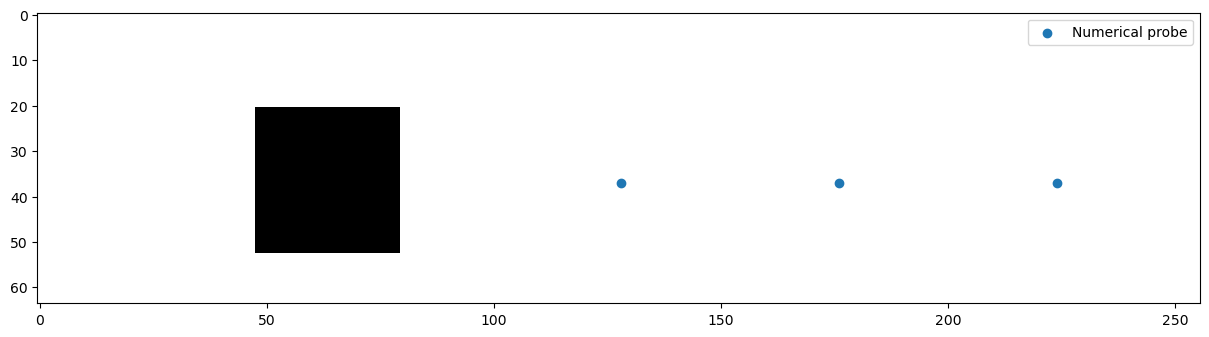

In [313]:
plt.figure(figsize=(15, 6))
plt.imshow(sigma[0,0,:,:].cpu(),cmap='gray_r')
if T_stat == True:
    plt.scatter(p_x,p_y,label='Numerical probe')
    plt.legend()

## Run AI4CFD solver

In [314]:
start = time.time()
print("======================================================================")
print("Welcome to AI4CFD solver that will generate flow past a block for you!")
print("======================================================================")
print("Summarising basic numerical setup before running AI4CFD code..........")
print(f'inflow speed from left to right --- {-ub} (m/s)')
print(f'Time step ------------------------- {dt} (s)')
print(f'Grid size ------------------------- {dx} (m)')
print(f'block size ------------------------ {size_x*2} (m)')
print(f'Reynolds number ------------------- {-ub*size_x*2/nu} (-)')
if T_stat == True:
    print("You are saving time series results!")
if L_save == True:
    print("You are saving spatial results!")
print("======================================================================")
print("Hello World, AI4CFD is running now!")
with torch.no_grad():
    for itime in range(1,ntime+1):
        [values_u,values_v,values_p,w,r] = AI4CFD(values_u,values_uu,values_v,values_vv,values_p,values_pp,sigma,b_uu,b_vv,dt,iteration)
        if itime % n_check == 0:
            print('Time step:', itime, 'Pressure residual:',"{:.5f}".format(np.max(np.abs(w.cpu().detach().numpy()))))  
        if np.max(np.abs(w.cpu().detach().numpy())) > 80000.0:
            print('Not converged !!!!!!')
            break
        if L_save and itime % n_out == 0:
            np.save(filepath+"/u"+str(itime), arr=values_u.cpu().detach().numpy())
            np.save(filepath+"/v"+str(itime), arr=values_v.cpu().detach().numpy()) 
        if T_stat == True:
            for k in range(N_p):
                num_p[k,itime-1] = values_u[0,0,p_y[k],p_x[k]] 
end = time.time()
print('Elapsed time:', end - start)
print("Goodbye World, AI4CFD is sleeping now!")

Welcome to AI4CFD solver that will generate flow past a block for you!
Summarising basic numerical setup before running AI4CFD code..........
inflow speed from left to right --- 1.0 (m/s)
Time step ------------------------- 0.05 (s)
Grid size ------------------------- 1.0 (m)
block size ------------------------ 32 (m)
Reynolds number ------------------- 640.0 (-)
You are saving time series results!
You are saving spatial results!
Hello World, AI4CFD is running now!
Time step: 100 Pressure residual: 0.32665
Time step: 200 Pressure residual: 0.16654
Time step: 300 Pressure residual: 0.08630
Time step: 400 Pressure residual: 0.11338
Time step: 500 Pressure residual: 0.10446
Time step: 600 Pressure residual: 0.14815
Time step: 700 Pressure residual: 0.16406
Time step: 800 Pressure residual: 0.10274
Time step: 900 Pressure residual: 0.07851
Time step: 1000 Pressure residual: 0.01553
Time step: 1100 Pressure residual: 0.04673
Time step: 1200 Pressure residual: 0.07333
Time step: 1300 Pressur

## Visualise u component velocity in x direction

Text(0.5, 1.0, 'u component velocity (m/s)')

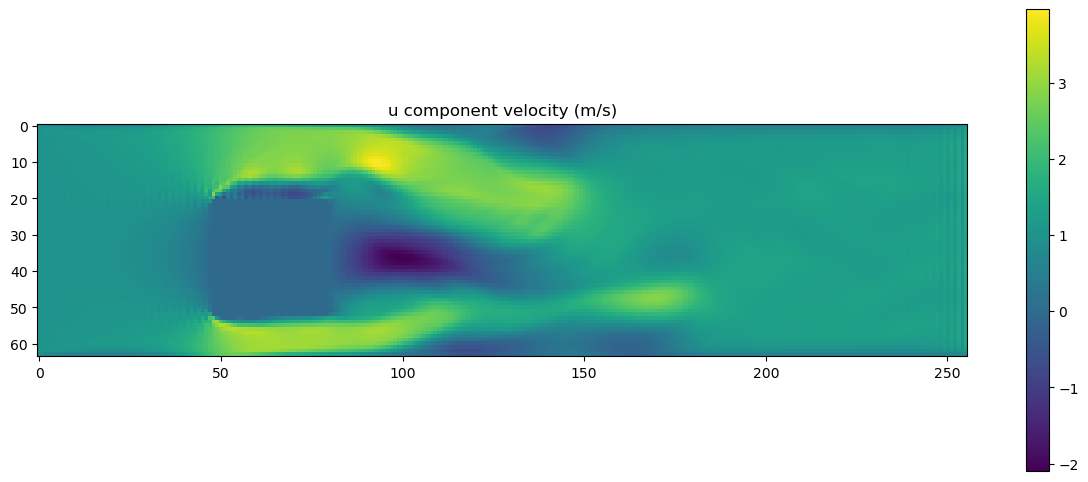

In [318]:
plt.figure(figsize=(15, 6))
plt.imshow(-values_u[0,0,:,:].cpu())
plt.colorbar()
plt.title('u component velocity (m/s)')
# plt.axis('off')

## Visualise v component velocity in y direction

Text(0.5, 1.0, 'v component velocity (m/s)')

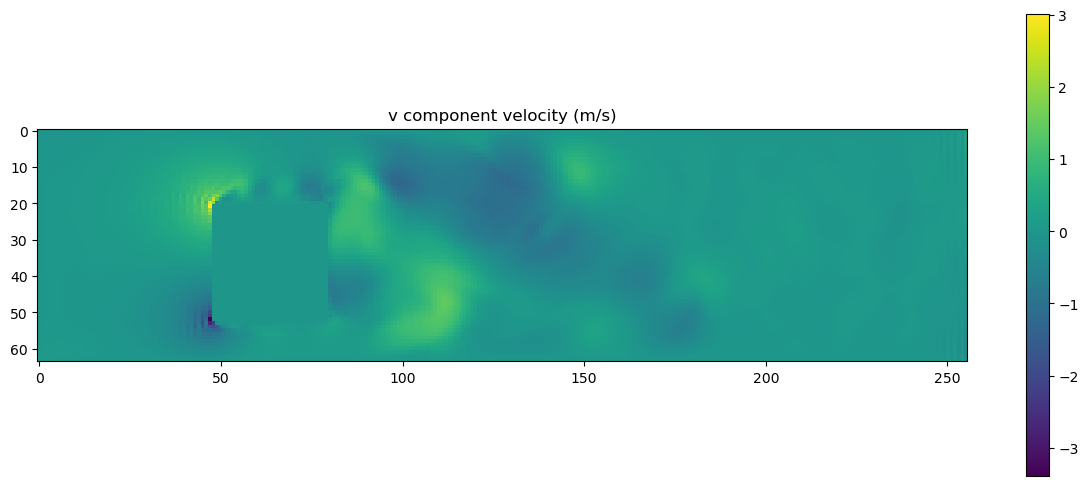

In [319]:
plt.figure(figsize=(15, 6))
plt.imshow(-values_v[0,0,:,:].cpu())
plt.colorbar()
plt.title('v component velocity (m/s)')

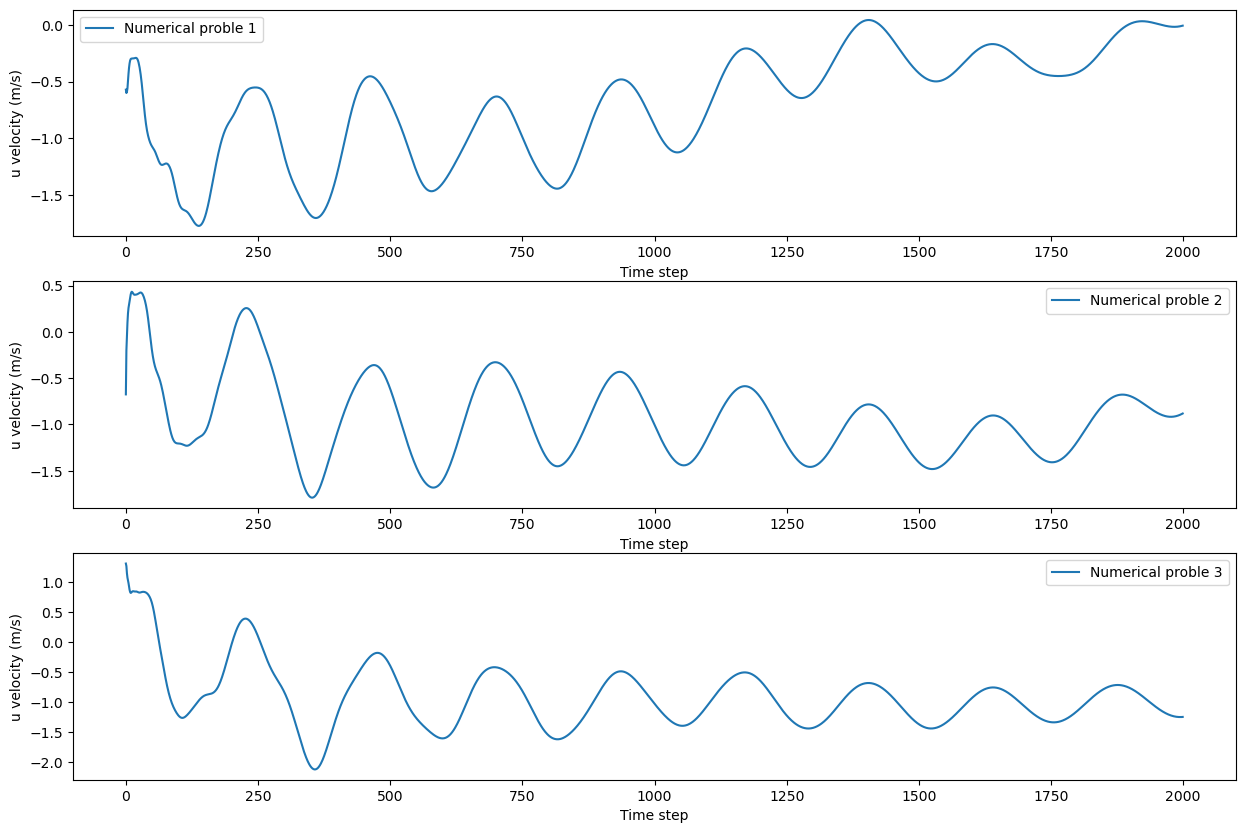

In [320]:
plt.figure(figsize=(15, 10))
for i in range(N_p):
    plt.subplot(N_p,1,i+1)
    plt.plot(num_p[i,:],label=f'Numerical proble {i+1}')
    plt.legend()
    plt.xlabel('Time step')
    plt.ylabel('u velocity (m/s)')